In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
sys.path.append("../")

import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import re

from model import build_model
from clip_ import load, tokenize, similarity_score
from vit_cam import interpret_vit, interpret_perword_vit
from rn_cam import interpret_rn, interpret_perword_rn
sys.path.append("../pytorch-grad-cam")
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
model_rn, preprocess = load("RN101", device=device, jit=False)
model_vit, preprocess = load("ViT-B/32", device=device, jit=False)

100%|███████████████████████████████████████| 292M/292M [00:26<00:00, 11.1MiB/s]
100%|███████████████████████████████████████| 354M/354M [00:13<00:00, 26.2MiB/s]


In [15]:
root = "../../Images/"
res_dir = "../../results/per_word/"

if not os.path.exists(res_dir):
    os.mkdir(res_dir)
    
img_ids = ['scary_painting_colorful.jpg', 'happy_woman.jpg', 'el2.jpeg', 'cow&sheep.jpg']


texts= ["scary clown with red hair",
        "happy woman with pink shirt", 
        "an elephant and a zebra ",
        "a cow and a sheep"]

model_types = ["ViT", "ResNet"]


font = {
    'size': 15,
}

ori_preprocess = Compose([
        Resize((224), interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        ToTensor()])

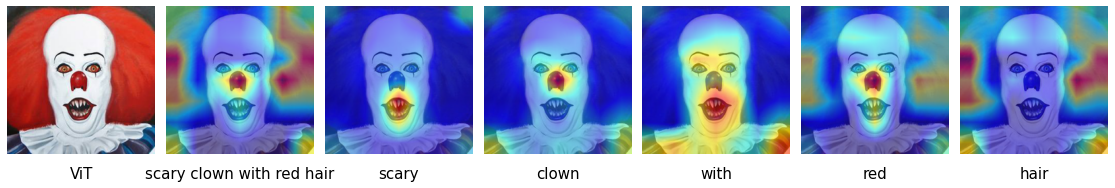

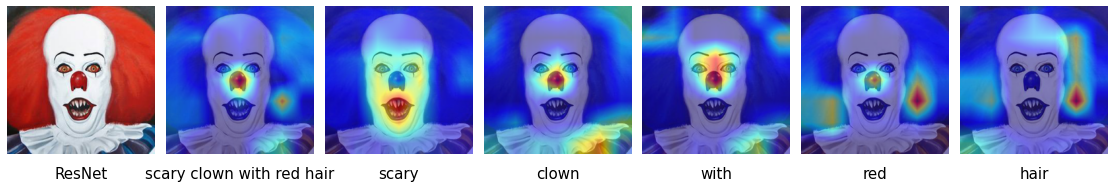

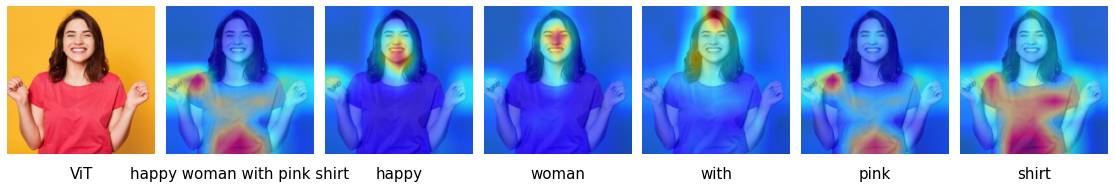

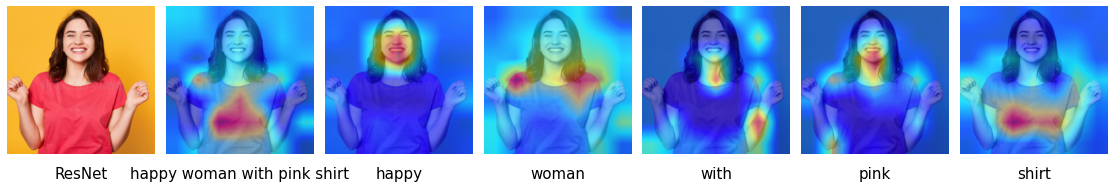

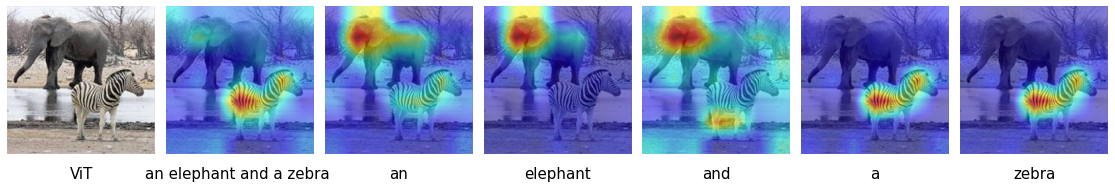

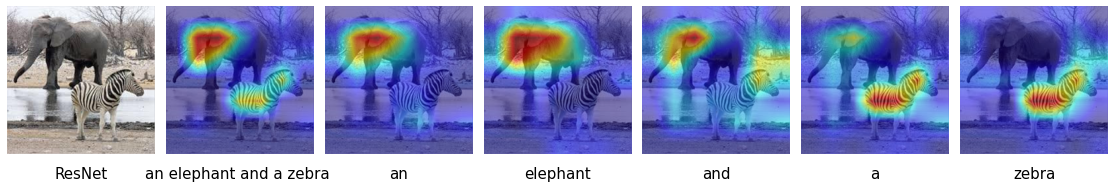

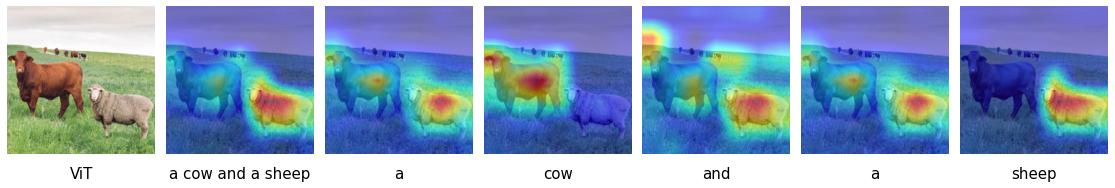

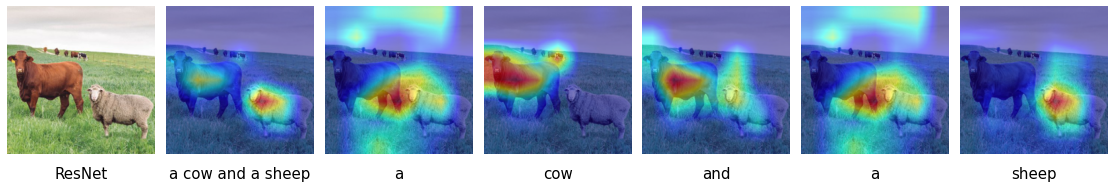

In [16]:
for id_, img_id in enumerate(img_ids):
    
    for model_id, model_type in enumerate(model_types):
        
        img_path =  os.path.join(root, img_id)
        image = ori_preprocess(Image.open(img_path))
        p_image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
        
        text = texts[id_]
        t_text = tokenize(text).to(device)
        words = text.split()


        plt.figure(figsize=(20, 20))
        plt.tight_layout()
        plt.subplot(191)
        plt.imshow(image.permute(1, 2, 0))
        plt.axis('off')
        plt.title(f"{model_type}", **font, y=-0.20)
    
        
        subplot = 193
        if model_type=="ViT":
           
            text_features = model_vit.encode_text(t_text)
            
            plt.subplot(192)
            interpret_vit(p_image.type(model_vit.dtype), text_features, model_vit.visual, device)
            
            plt.axis('off')
            plt.title(text, **font,y=-0.20)
            plt.tight_layout()
            

            for w,word in enumerate(words):
               
                plt.subplot(subplot+w)
                
                interpret_perword_vit(p_image, text, model_vit, tokenize, device, masked_word=word)
                
                plt.axis('off')
                plt.title(word, **font,y=-0.20)
                plt.tight_layout()

        else:
            text_features = model_rn.encode_text(t_text)
            
            plt.subplot(192)
            
            interpret_rn(p_image, text_features, model_rn.visual, GradCAM, device)
            
            plt.axis('off')
            plt.title(text, **font,y=-0.20)
            plt.tight_layout()
           
            
            for w,word in enumerate(words):
                
                plt.subplot(subplot+w)
                
                interpret_perword_rn(p_image, text, model_rn, tokenize, GradCAM, device, masked_word=word)
               
                plt.axis('off')
                plt.title(word, **font,y=-0.20)
                plt.tight_layout()
      
        
        plt.savefig(res_dir+f'{model_type}_{img_id}', bbox_inches='tight')
